In [28]:
import string 
import re 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/main_data.csv', index_col=0)

In [4]:
df.head()

,Label,Text
0,yue,你點解唔同我哋講嘅？
1,yue,你要食早餐啊。
2,yue,你同我講嘢？
3,yue,放開佢！
4,yue,你成世人收過最正嘅聖誕禮物係咩呀？


In [4]:
df.Label.value_counts()

tgl    6000
ind    6000
por    6000
eng    6000
jpn    6000
       ... 
kzj    3685
est    3613
tha    3495
tam    1469
kan     369
Name: Label, Length: 79, dtype: int64

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435505 entries, 0 to 435519
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Label   435505 non-null  object
 1   Text    435505 non-null  object
dtypes: object(2)
memory usage: 10.0+ MB


In [119]:
df.shape

(435520, 2)

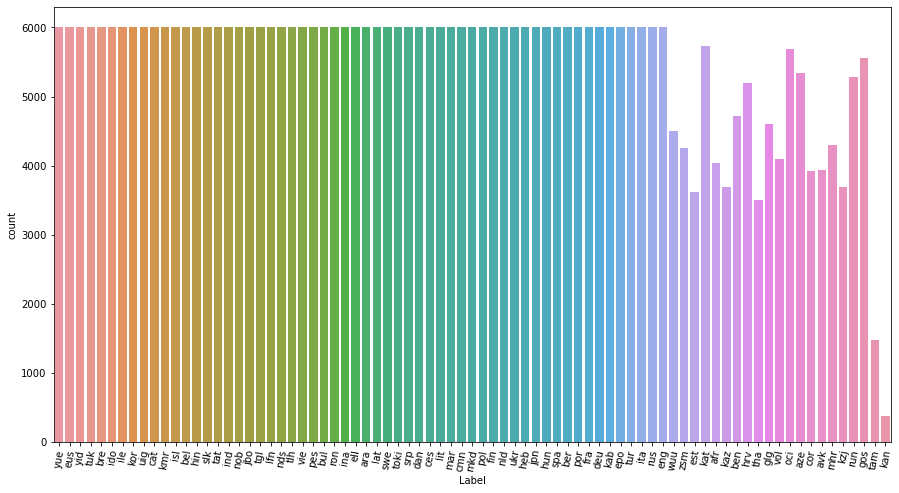

In [16]:
plt.figure(figsize=(15,8))
sns.countplot(x=df.Label)
plt.xticks(rotation=80)
plt.show();


#### Note we added approx 500 samples of kannada language which is less but we will use characters to classify so it should be fine

In [31]:
labels = pd.read_csv('data/lang_codes.txt', encoding='utf-8', sep='	', names=['iso1','iso2', 'English', 'French', 'German'])

In [32]:
labels.head()

,iso1,iso2,English,French,German
0,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language
1,aar,aa,Afar,afar,Danakil-Sprache
2,abk,ab,Abkhazian,abkhaze,Abchasisch
3,ace,,Achinese,aceh,Aceh-Sprache
4,ach,,Acoli,acoli,Acholi-Sprache


note we will use this language code at time of prediction

In [51]:
def plot_word_cloud(data):
    words= ''
    for sent in data:
        sent =str(sent)
        tokens = sent.split()
        words += ' '.join(tokens)+ ' '
    # now plot word clou
    wordcloud = WordCloud(width=800, height=800, background_color='aqua').generate(words)
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

wordcloud for english

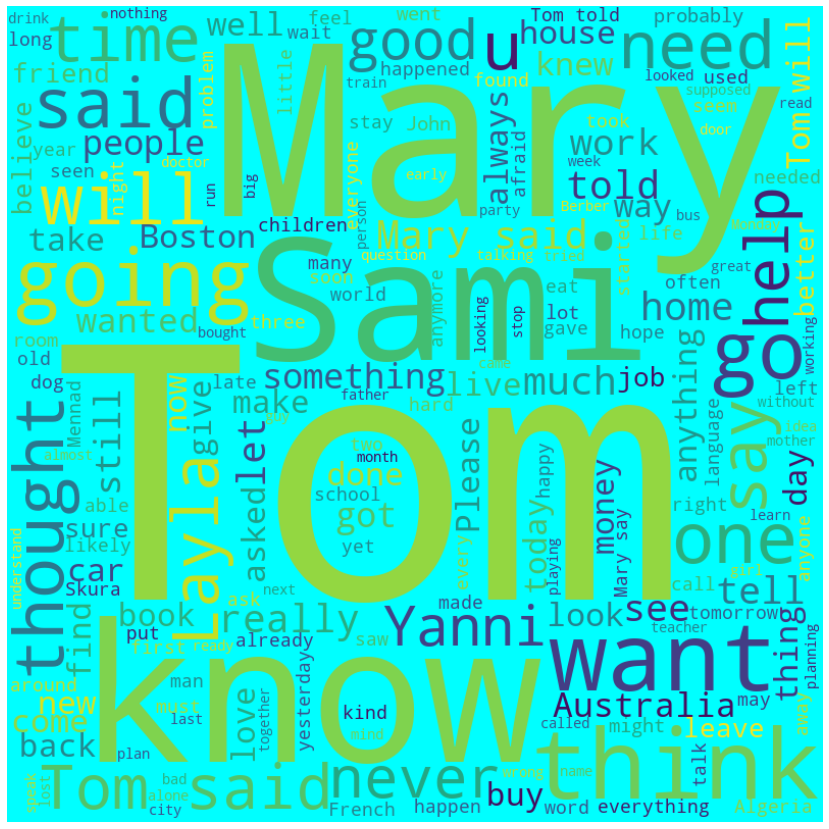

In [52]:
plot_word_cloud(df.Text.where(df.Label=='eng').dropna())

## Preprocess text

***note in language detection we don't need digits or punchuations we will drop them***

In [5]:
for char in string.punctuation:
    print(char,end =" ")

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ 

In [6]:
translate_table= dict((ord(char),None) for char in string.punctuation)

In [7]:
xyz= 'hi my + , - . / : ; name os'
xyz.translate(translate_table)

'hi my        name os'

In [8]:
xyz= 'hi my name 00 4s'

re.sub('\d+','',xyz)

'hi my name  s'

#### lower case all text

In [9]:
df.Text = df.Text.apply(lambda x: x.lower())

#### drop all Digits

In [10]:
df.Text = df.Text.apply(lambda x: re.sub('\d+','',x))

#### drop all Punchuations

In [11]:
df.Text = df.Text.apply(lambda x: x.translate(translate_table))

In [12]:
df.Text.sample(10)

84297                               prečo je tato v kuchyni
202521                      пробао сам да се попнем уз дрво
389866    kikobohingkangan zou do monoina om tumoguvang ...
240238                  nawyki są trudne do przezwyciężenia
186110                             kan du lära mig engelska
97743            kita tidak sampai harus menjual rumah kita
412293                                        წიგნი წითელია
369968               আমি জানি আমরা একে অপরকে এখনো ভালোবাসি।
364738    my vader het gese ek mag nie alleen oorsee gaa...
386551                                               sjedni
Name: Text, dtype: object

note: data is clean now

In [13]:
df.isna().sum()

Label    15
Text      0
dtype: int64

In [14]:
df.dropna(inplace=True)

## split into x and y

In [15]:
X= df.Text
y = df.Label

stratify splits data evenly

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((348404,), (87101,), (348404,), (87101,))

#### Note we will use Tf* idf verctorizer to convert text into digit

## model1

In [133]:
vectorizer = TfidfVectorizer()


In [142]:
model1= pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression())
])

In [143]:
model1.fit(X_train, y_train)

D:\Machine_learning\Recurrent_Neural_Network\Recurrent_Env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [144]:
model1.score(X_test, y_test)

0.8485092019609419

save model

In [147]:
with open('saved_models/lr1.pckl','wb') as fp:
    pickle.dump(model1,fp)



load model

In [18]:
model1 = pickle.load(open('saved_models/lr1.pckl', 'rb'))

In [33]:
model1.score(X_test,y_test)

0.8485092019609419

In [60]:
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import classification_report, confusion_matrix

classification report

In [20]:
pred1 = model1.predict(X_test)

#### Visit here to see diffrent color palets

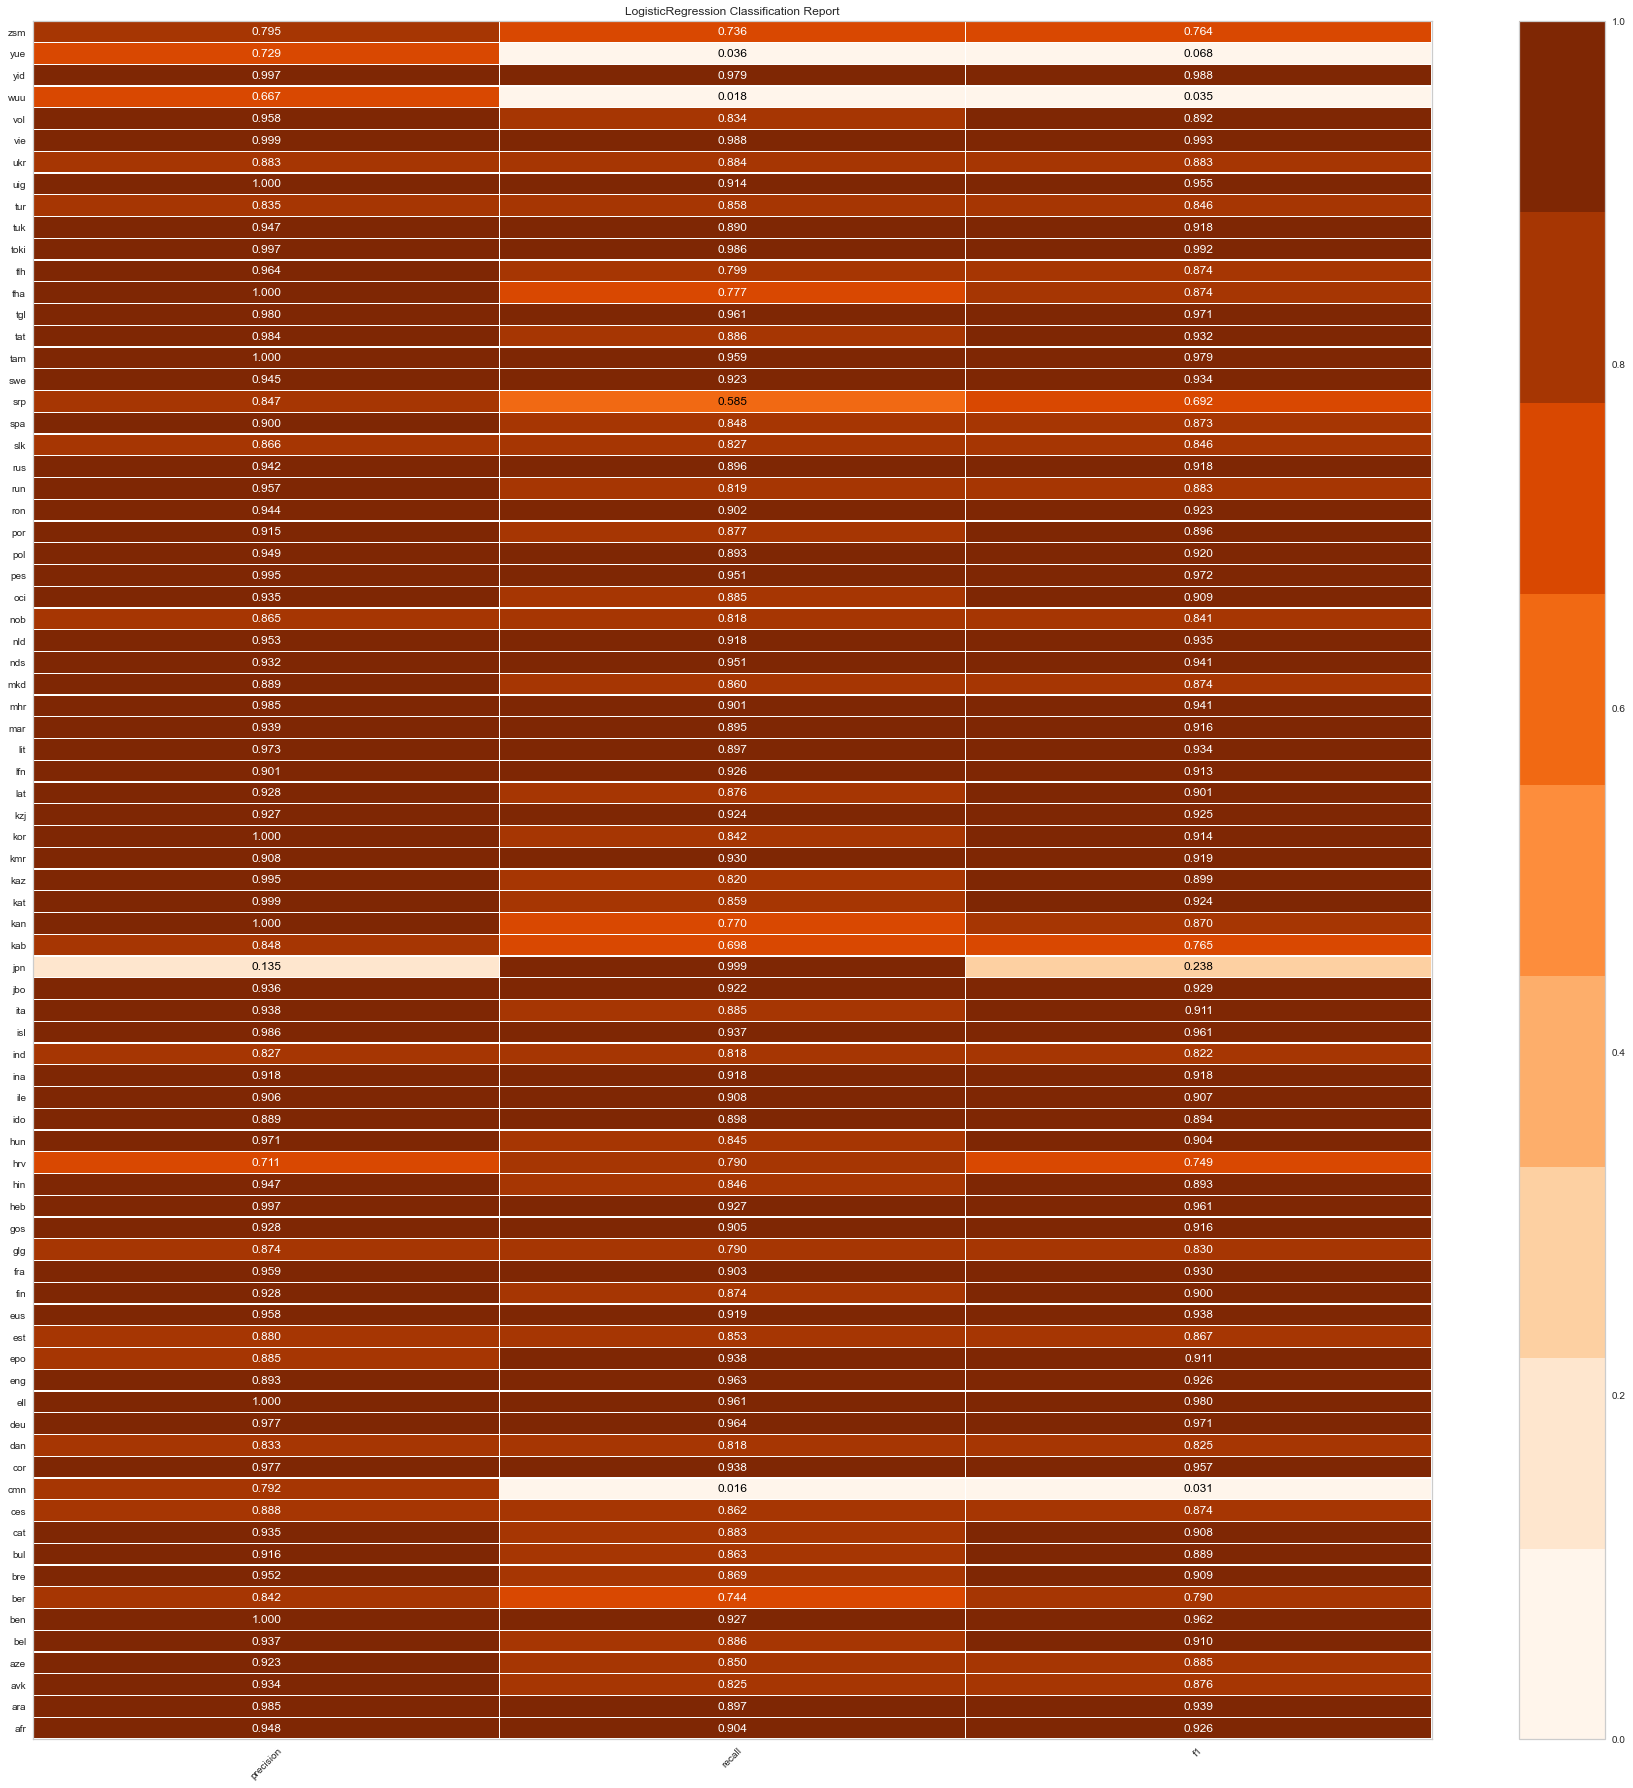

ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000026FE7606CD0>,
                     estimator=Pipeline(steps=[('vectorizer',
                                                TfidfVectorizer()),
                                               ('clf', LogisticRegression())]),
                     is_fitted=True)

In [45]:
plt.figure(figsize=(25,25))
classification_report(model1,X_train,y_train,X_test,y_test,is_fitted=True, cmap='Oranges')

# model 2

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),analyzer='char')


In [24]:
model2= pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression())
])

In [25]:
model2.fit(X_train, y_train)

D:\Machine_learning\Recurrent_Neural_Network\Recurrent_Env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('clf', LogisticRegression())])

In [28]:
with open('saved_models/lr2.pckl','wb') as fp:
    pickle.dump(model2,fp)


In [29]:
model2.score(X_test, y_test)

0.9504138873262075

In [43]:
model2= pickle.load(open('saved_models/lr2.pckl', 'rb'))

In [52]:
pred2 = model2.predict(X_test)

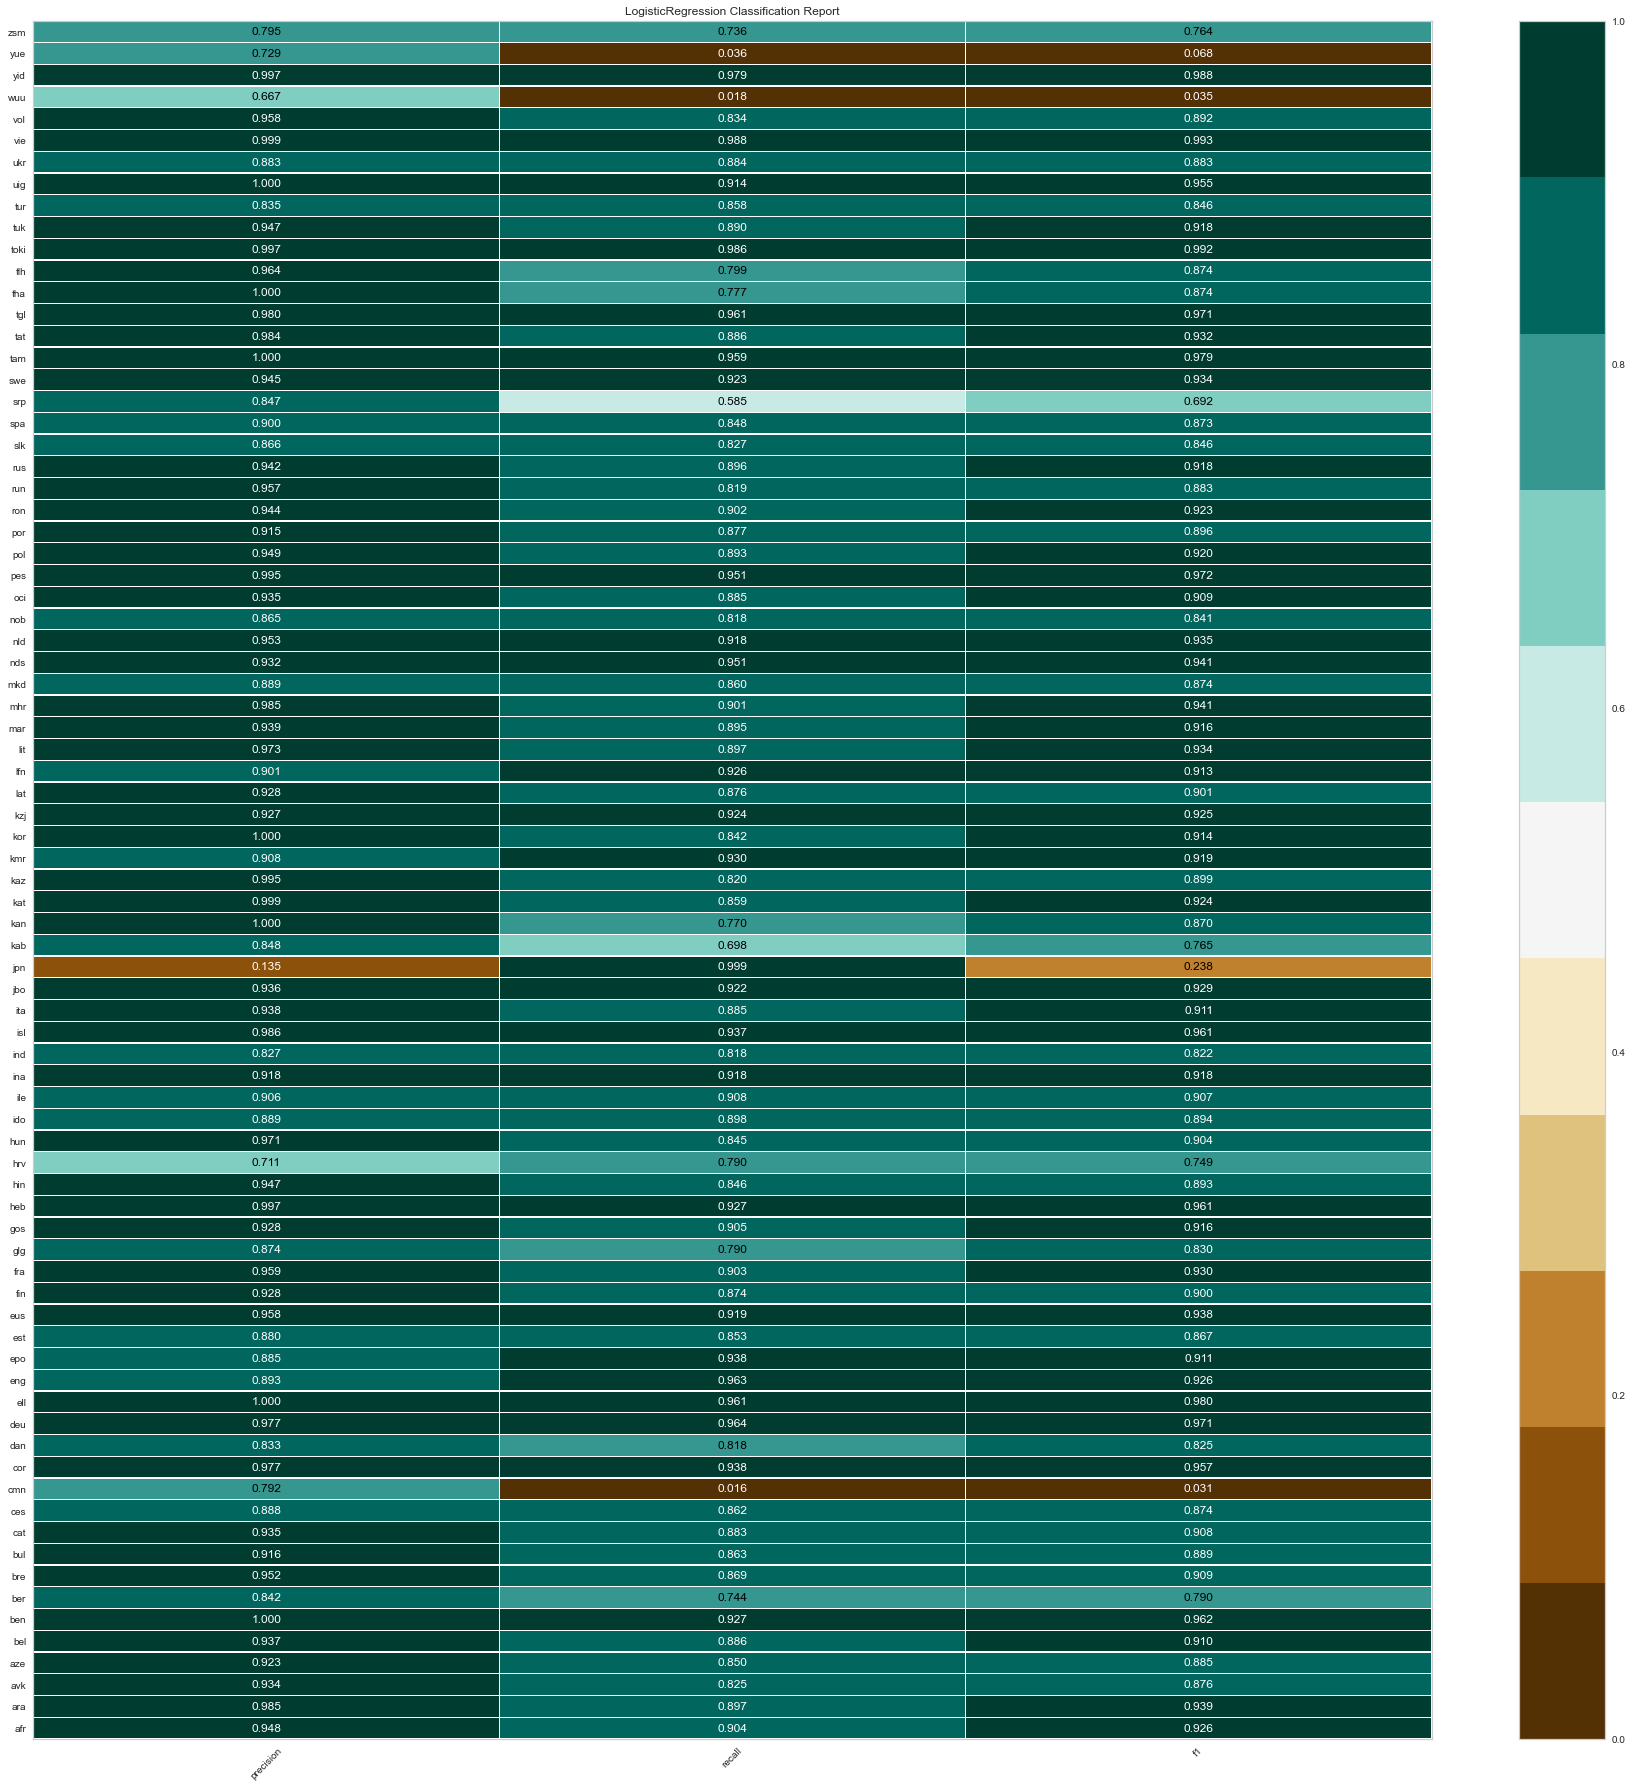

ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000026FE7E57C40>,
                     estimator=Pipeline(steps=[('vectorizer',
                                                TfidfVectorizer()),
                                               ('clf', LogisticRegression())]),
                     is_fitted=True)

In [53]:
plt.figure(figsize=(25,25))
classification_report(model1,X_train,y_train,X_test,y_test,is_fitted=True, cmap='BrBG')

## Make prediction on custom data

In [94]:
labels.head()

,iso1,iso2,English,French,German
0,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language
1,aar,aa,Afar,afar,Danakil-Sprache
2,abk,ab,Abkhazian,abkhaze,Abchasisch
3,ace,,Achinese,aceh,Aceh-Sprache
4,ach,,Acoli,acoli,Acholi-Sprache


#### Creating fuction to get name of language from code

In [84]:
def get_pred_label(pred):
    '''
    using languages iso codes gets Englsih name of language
    '''
    x= labels.English.where(labels.iso1==pred[0]).dropna().tolist()
    return x[0]

In [87]:
text= ['hi this is me']
get_pred_label(model2.predict(data))

'English'

In [88]:
text=['தமிழ் செய்திகள் தட்ஸ்தமிழ்']
get_pred_label(model2.predict(text))

'Tamil'

In [89]:
text=['ಇಟ್ಸ್ ವೆರಿ ಈಜಿ ಅಂಡ್ ಸಿಂಪಲ್ ']
get_pred_label(model2.predict(text))

'Kannada'

In [90]:
text=['जगभरातल्या ताज्या बातम्या, लेख आणि व्हीडिओ.']
get_pred_label(model2.predict(text))

'Marathi'

In [91]:
text=['日本の大気汚染の歴史']
get_pred_label(model2.predict(text))

'Japanese'

In [92]:
text=['Встре́ча с медве́дем мо́жет быть о́чень опа́сна. Ру́сские лю́ди лю́бят ходи́ть в лес и собира́ть']
get_pred_label(model2.predict(text))

'Russian'